# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [360]:
# import libraries
import yaml
import re
import numpy as np
import pandas as pd
import chardet
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pickle

import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

URL_REGEX = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


[nltk_data] Downloading package punkt to /Users/mxagar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mxagar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mxagar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
# Run SELECT * query
df = pd.read_sql("SELECT * FROM Message", engine)

In [15]:
df.shape

(26216, 40)

In [11]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [43]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df.isna().sum(axis=0)

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

In [49]:
df.dropna(subset=["message"], inplace=True)

In [35]:
df.genre.value_counts()

news      13054
direct    10766
social     2396
Name: genre, dtype: int64

In [36]:
df.iloc[:,4:].sum(axis=0)

related                   20282
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

['child_alone', 'offer', 'shops', 'tools', 'fire', 'hospitals', 'missing_people', 'aid_centers', 'clothing', 'security', 'cold', 'electricity', 'money', 'search_and_rescue', 'military', 'refugees', 'other_infrastructure', 'death', 'transport', 'medical_products', 'buildings', 'other_weather', 'water', 'infrastructure_related', 'medical_help', 'floods', 'shelter', 'storm', 'earthquake', 'food', 'other_aid', 'request', 'direct_report', 'weather_related', 'aid_related', 'related']


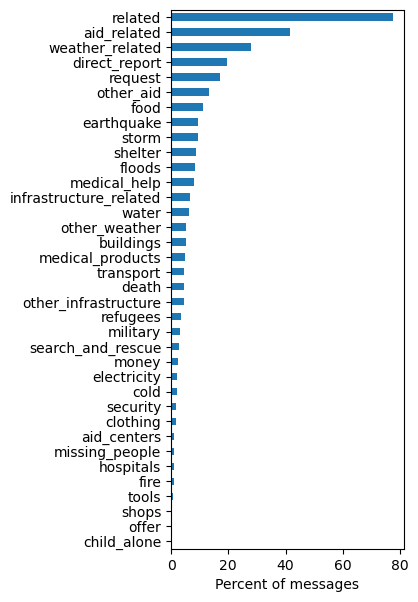

In [446]:
plt.figure(figsize=(3,7))
s = 100*df.iloc[:,4:].sum(axis=0)/df.shape[0]
s.sort_values(ascending=True).plot(kind='barh')
print(list(s.sort_values(ascending=True).index))
plt.xlabel("Percent of messages")
plt.show()

### 2. Write a tokenization function to process your text data

In [362]:
from string import punctuation

In [363]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [367]:
def tokenize(text):
    """Perform the NLP:
    
    - Clean
    - Normalize (to lower)
    - Tokenize
    - Lemmatize
    
    Args:
        text (string): message
    
    Returns:
        clean_tokens (list): list of processed lemmas
    """
    #detected_urls = re.findall(URL_REGEX, text)
    #for url in detected_urls:
    #    text = text.replace(url, "urlplaceholder")
    # Remove punctuation
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text =  ''.join([c for c in text if c not in punctuation])

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [368]:
from sklearn.multioutput import MultiOutputClassifier

In [369]:
with open("../config.yaml") as f: # 'config.yaml'
    config = yaml.safe_load(f)

In [370]:
categorical_columns = ['genre']
nlp_columns = ['message']
target_columns = ['related', 'request', 'offer',
    'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
    'security', 'military', 'child_alone', 'water', 'food', 'shelter',
    'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
    'infrastructure_related', 'transport', 'buildings', 'electricity',
    'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
    'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
    'other_weather', 'direct_report']

In [371]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """Custom transformer. Guidelines:

    - Always define fit() and transform()
    and return self if there is nothing to return. 
    - Define __init__() if attributes need to be stored.
    
    This custom transformer returns True if any of the sentences
    in the text/message starts with a verb; otherwise, False."""
    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [372]:
# In order to be able to serialize an object (pickle)
# we cannot use lambdas in it

def squeeze(x):
    """Squeeze array."""
    return x.squeeze()

def toarray(x):
    """Convert to array."""
    return x.toarray()

In [373]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))])

"""
nlp_transformer = Pipeline(steps=[
    ('nlp', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
            ])),
        ('starting_verb', StartingVerbExtractor())
        ])
    )])
"""

# CountVectorizer and TfidfTransformer have some issues
# with the size of the arrays, and they require some reshaping
# as done here with FunctionTransformer
nlp_transformer = Pipeline([
    #('reshape', FunctionTransformer(np.reshape, kw_args={"newshape": -1})),
    #("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("squeeze", FunctionTransformer(squeeze)),
    ('vect', CountVectorizer(tokenizer=tokenize, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    #("toarray", FunctionTransformer(lambda x: x.toarray())),
    ("toarray", FunctionTransformer(toarray)),
])

text_transformer = FeatureUnion([
    ('nlp', nlp_transformer),
    ('starting_verb', StartingVerbExtractor())
])

processor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_columns),
        ("nlp", nlp_transformer, nlp_columns),
        #("text", text_transformer, nlp_columns),
    ],
    remainder="drop",  # This drops the columns that we do not transform
)

# MultiOutputClassifier is used to handle N-D target
# However note that "this strategy consists in fitting one classifier per target",
# thus, it will take much longer (xN)
pipe = Pipeline(
    steps=[
        #("processor", processor),
        ("processor", nlp_transformer),
        ("classifier", MultiOutputClassifier(
            RandomForestClassifier(**config["random_forest_parameters"]))),
        #("classifier", RandomForestClassifier(**config["random_forest_parameters"])),
    ]
)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [374]:
# Connect to database
engine = create_engine(f"sqlite:///../data/DisasterResponse.db")
# Run SELECT * query; WATCH OUT: Using this SQL query text requires sqlalchemy<2.0
df = pd.read_sql("SELECT * FROM Message", engine)

In [375]:
#X = df[config['nlp_columns']+config['categorical_columns']]
X = df[config['nlp_columns']]
Y = df[config['target_columns']]

In [376]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=config["test_size"],
                                                    random_state=config["random_seed"])

In [377]:
#pipe.fit(X_train, Y_train['aid_related'])
pipe.fit(X_train, Y_train)

Pipeline(steps=[('processor',
                 Pipeline(steps=[('squeeze',
                                  FunctionTransformer(func=<function squeeze at 0x1728d45e0>)),
                                 ('vect',
                                  CountVectorizer(token_pattern=None,
                                                  tokenizer=<function tokenize at 0x1728d43a0>)),
                                 ('tfidf', TfidfTransformer()),
                                 ('toarray',
                                  FunctionTransformer(func=<function toarray at 0x1728f5af0>))])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=13,
                                                                        random_state=42)))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [383]:
Y_pred = pipe.predict(X_test)

In [384]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [385]:
for i in range(len(Y_test.columns)):
    print(f"\nTarget column: {Y_test.columns[i]}")
    print(classification_report(Y_test.iloc[:,i],Y_pred[:,i]))


Target column: related
              precision    recall  f1-score   support

           0       0.49      0.62      0.54      1266
           1       0.86      0.78      0.82      3938
           2       0.34      0.75      0.47        40

    accuracy                           0.74      5244
   macro avg       0.56      0.72      0.61      5244
weighted avg       0.77      0.74      0.75      5244


Target column: request
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      4349
           1       0.57      0.72      0.64       895

    accuracy                           0.86      5244
   macro avg       0.76      0.80      0.78      5244
weighted avg       0.88      0.86      0.87      5244


Target column: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5218
           1       0.00      0.00      0.00        26

    accuracy                           0.99      5244
   m

/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [390]:
import joblib
import skops.io as sio

In [392]:
model_artifact = "../models/classifier.pkl"
with open(model_artifact, 'wb') as f:
    # wb: write bytes
    sio.dump(pipe, f)

In [394]:
with open(model_artifact, 'rb') as f: # 'models/classifier.pkl'
    model = sio.load(f, trusted=True)

In [395]:
model.predict(X_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]])

### 6. Improve your model
Use grid search to find better parameters. 

In [245]:
#parameters = {
#    'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
#    'clf__n_estimators': [50, 100, 200],
#    'clf__min_samples_split': [2, 3, 4]
#}'
param_grid = {
    'classifier__estimator__n_estimators': config["grid_search"]["hyperparameters"]["n_estimators"], # 100, 200
    'classifier__estimator__min_samples_split': config["grid_search"]["hyperparameters"]["min_samples_split"] # 2, 3
}
grid = GridSearchCV(pipe,
                    param_grid=param_grid,
                    #scoring=config["grid_search"]["scoring"], # "f1"
                    cv=config["grid_search"]["cv"]) # 3

In [ ]:
grid = grid.fit(X_train, Y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [201]:
Y_pred = grid.predict(X_test)

In [206]:
for i in range(len(Y_test.columns)):
    print(f"\nTarget column: {Y_test.columns[i]}")
    print(classification_report(Y_test.iloc[:,i],Y_pred[:,i]))


Target column: related
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      1254
           1       0.86      0.80      0.83      3952
           2       0.20      0.79      0.32        38

    accuracy                           0.74      5244
   macro avg       0.52      0.72      0.56      5244
weighted avg       0.77      0.74      0.75      5244


Target column: request
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      4345
           1       0.51      0.77      0.61       899

    accuracy                           0.83      5244
   macro avg       0.73      0.81      0.75      5244
weighted avg       0.87      0.83      0.85      5244


Target column: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5222
           1       0.10      0.05      0.06        22

    accuracy                           0.99      5244
   m

/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mxagar/opt/anaconda3/envs/dis-res/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [208]:
grid.best_params_

{'classifier__estimator__min_samples_split': 2,
 'classifier__estimator__n_estimators': 200}

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [213]:
import pickle
import joblib

In [218]:
model_artifact = "../models/classifier.pkl"
with open(model_artifact, 'wb') as f:
    # wb: write bytes
    pickle.dump(grid.best_estimator_, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### 11. Tests

In [402]:
import disaster_response as dr

In [403]:
config = dr.load_validate_config(config_filename="../config.yaml")

In [413]:
X, Y = dr.load_XY(config['categorical_columns'],
                config['nlp_columns'],
                config['target_columns'],
                "../data/DisasterResponse.db")

In [414]:
X

,message
0,Weather update - a cold front from Cuba that c...
1,Is the Hurricane over or is it not over
2,Looking for someone but no name
3,UN reports Leogane 80-90 destroyed. Only Hospi...
4,"says: west side of Haiti, rest of the country ..."
...,...
26211,The training demonstrated how to enhance micro...
26212,A suitable candidate has been selected and OCH...
26213,"Proshika, operating in Cox's Bazar municipalit..."
26214,"Some 2,000 women protesting against the conduc..."


In [405]:
type(X)

pandas.core.frame.DataFrame

In [406]:
X.shape

(26216, 1)

In [411]:
type(X.values)

numpy.ndarray

In [416]:
pd.Series(X['message']).shape

(26216,)

In [417]:
model = dr.load_validate_model(model_artifact="../"+config['model_filepath'])

In [419]:
#classification_labels = model.predict()

In [441]:
messages = pd.DataFrame(data=["test",""], columns=['message'])

In [442]:
classification_labels = model.predict(messages)

In [444]:
classification_labels[0]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])